In [1]:
# -*- coding: utf-8 -*-
"""
Titulo: Automatizacion reportes regionales
Created on Thu Aug 22 11:58:39 2019

Proceso que automatiza reportes regionales, generando un documento word por cada region.

Obs: Se deben revisar los inputs antes de correr

@author: hugo.gallardo
"""

# =============================================================================
# Extracción en python de datos de comunicado de compras a nivel regional
# =============================================================================

#Seteo de librerias

import pandas as pd
import numpy as np
import sqlalchemy as sa              #Para conexión a BD, requerido para usar pd.read_sql()
import urllib                        #Para formatear string de conexión

import docx
import matplotlib.pyplot as plt 
import matplotlib.patches as mpatches
import openpyxl as opxl             # OJO EN LA CASA para importar excel como dataframe

from docx import Document
from docx import shared
from docx.shared import Inches
from docx.enum.text import WD_ALIGN_PARAGRAPH
from docx.enum.text import WD_LINE_SPACING
from docxtpl import DocxTemplate, InlineImage   #rellenar templates

import seaborn as sns
import os
import sys
from pylab import savefig
import itertools

import pyodbc                               ### another engine to make DB connection and run the queries. Alternative to sqlalchemy
from itertools import repeat
import querysGR as qg

In [2]:
#Transforma codigo a word
#Agregar github


#Conexion a DW

#param = urllib.parse.quote_plus("DRIVER={SQL Server};SERVER=10.34.71.202;UID=datawarehouse;PWD=datawarehouse;DATABASE=DM_Transaccional")#;Trusted_Connection=yes
#conn = sa.create_engine("mssql+pyodbc:///?odbc_connect=%s" % param)

#param = urllib.parse.quote_plus("DRIVER={SQL Server};SERVER=10.34.71.227;UID=eymetric;PWD=Eym3tr1c.2022;DATABASE=DM_Transaccional_2022")#;Trusted_Connection=yes
#conn = sa.create_engine("mssql+pyodbc:///?odbc_connect=%s" % param)

#A DCCPProcurement
#paramAQ = urllib.parse.quote_plus("DRIVER={ODBC Driver 13 for SQL Server};DATABASE=DCCPProcurement;SERVER=10.34.71.145;UID=datawarehouse;PWD=datawarehouse")
#bd = sa.create_engine("mssql+pyodbc:///?odbc_connect=%s" % paramAQ)
#paramAQ = urllib.parse.quote_plus("DRIVER={ODBC Driver 13 for SQL Server};SERVER=10.34.71.146;UID=datawarehouse;PWD=datawarehouse")
#bd = sa.create_engine("mssql+pyodbc:///?odbc_connect=%s" % paramAQ)


#**** BBDD *****

# Verificar Drivers

###### DW ######

param_DW = urllib.parse.quote_plus("DRIVER={SQL Server};SERVER=10.34.71.202;UID=datawarehouse;PWD=datawarehouse;DATABASE=DM_Transaccional;TrustServerCertificate=yes")
conn_DW = sa.create_engine("mssql+pyodbc:///?odbc_connect=%s" % param_DW)


##### DEV #####

param_dev = urllib.parse.quote_plus("DRIVER={/opt/microsoft/msodbcsql18/lib64/libmsodbcsql-18.2.so.2.1};SERVER=10.34.71.227;UID=eymetric;PWD=Eym3tr1c.2022;DATABASE=DM_Transaccional_2022;TrustServerCertificate=yes")
conn_dev = sa.create_engine("mssql+pyodbc:///?odbc_connect=%s" % param_dev)

##### AQUILES #####

param_AQ = urllib.parse.quote_plus("DRIVER={SQL Server};DATABASE=DCCPProcurement;SERVER=10.34.71.146;UID=datawarehouse;PWD=datawarehouse;DATABASE=DCCPProcurement;TrustServerCertificate=yes")
conn_AQ = sa.create_engine("mssql+pyodbc:///?odbc_connect=%s" % param_AQ)

### connections with pyodbc ###
conn_AQ_pyodbc=pyodbc.connect('DRIVER={SQL Server};DATABASE=DCCPProcurement;SERVER=10.34.71.146;UID=datawarehouse;PWD=datawarehouse;DATABASE=DCCPProcurement;TrustServerCertificate=yes')#;Encrypt=yes')#;TrustServerCertificate=yes')#;TrustServerCertificate=yes')
#conn_AQ_pyodbc = pyodbc.connect('DRIVER={SQL Server};SERVER=10.34.71.146;DATABASE=DCCPProcurement;UID=datawarehouse;PWD=datawarehouse')
cursor=conn_AQ_pyodbc.cursor()
#*************************

In [3]:
# =============================================================================
# Creando parametros y funciones para queries 
# =============================================================================


#url = "C:/Users/luis.recabarren/Documents/proyecto_statistics_tool/output/"
#url='/mnt/c/Users/luis.recabarren/Documents/proyecto_statistics_tool/output/'
#url = 'C:/Users/USER/OneDrive - DCCP/Documents/comunicaciones dpto/Reporte_cifras_MP_automatizado'
url = 'C:/o/OneDrive - DCCP/Escritorio/Dpt Comunicaciones/Reportes Automatizados'
#os.chdir(url)
AnoReg = 2023

#Funcion para reducir un Anio
def Anomenos1(Ano):
    Menos = Ano - 1
    return Menos


#entra numero y retorna valor con puntos en string
#abrevia en millones si supera 8 dígitos
#agrega símbolos monetarios
def fmtoEntero(x, mnd=''):
    ini = ''
    fin = ''

    #abrevia si supera 8 digitos
    if x >= 100000000: #me pareció que muestre al menos 3 dígitos
        x = x / 1000000
        fin = ' millones'
    
    #verificar formato de escritura
    if mnd == 'CLP':
        ini = '$'
    elif mnd == 'USD':
        ini = 'US $'
        #fin = fin + ' USD'
    elif mnd == 'CLF':
        if fin == ' millones':
            fin = fin + ' de UF'
        else:
            fin = fin + ' UF'
    
    x = format(int(round(x)),',d') #crea str de entero con puntuación
    x = x.replace(",",".") #formato de puntos latino

    return ini + x + fin


#entra tasa y retorna el porcentaje como string
def fmtoPorcien(x):
    x = x * 100
    x = format(x,',.1f') #crea str con 1 decimal y puntuación
    x = x.replace(".","a").replace(",",".").replace("a",",") #formato de puntos latino
    return x+'%'


#Agrega gráfico de torta, necesita datos, etiqueta y título
def graf_torta(x, labels, titGraf): 
    plt.clf()
    #plt.figure(figsize=(4.5,4.5))
    bordeG = {'linewidth' : 1, 'edgecolor' : 'white'}
    plt.pie(x
            , autopct='%.1f%%'
            , textprops=dict(color="grey", size=7.7)
            , pctdistance=1.15
            , wedgeprops = bordeG)
    legend = plt.legend(labels
                        , loc = "lower center"
                        , bbox_to_anchor=(0.27, -0.15, 0.5, 0.5)
                        , ncols = 3
                        , fontsize=7
                        , handlelength=0.7
                        , handleheight=0.7
                        ) 
    tituloG = plt.title("Montos transados por sector " + titGraf ,fontweight="bold",fontsize=16)
    
    plt.savefig(titGraf+'.png')


#retorna string aumento/disminución según variacón entregada
def palabraVar(var):
    plb = 'manteción' #es necesario?
    if var > 0:
        plb = 'aumento'
    elif var < 0:
        plb = 'disminución'
    return plb

###
### Funcion para definir si es mayor el top requerido o los datos del df
###

#Borrar
AnoRegM1 = Anomenos1(AnoReg)

#Si es semestral, agregar meses correspondientes
MesInferior = 1
MesSuperior = 11

#Agregar que semestre es:
Sem = "primer"
tri='primer' #'segundo' ,etc

anoReg = AnoReg
anoRegM = AnoRegM1

FechaQ = pd.Series([AnoReg,AnoRegM1, MesInferior,MesSuperior])

# =============================================================================
# Fin Inputs
# =============================================================================

In [4]:
# =============================================================================
# Setteo Diccionarios Regionales y Nacional
# =============================================================================
                                  
# Diccionario Regional, adaptar nombres de BBDD
# Usar BBDD? Renombrar para diccionario con mas datos??
RegNomb =  {'Antofagasta':              {'nom':'Región de Antofagasta',                  'nomCt':'Antofagasta'},
            'Araucanía':                {'nom':'Región de La Araucanía',                 'nomCt':'La Araucanía'},
            'Arica y Parinacota':       {'nom':'Región de Arica y Parinacota',           'nomCt':'Arica y Parinacota'},
            'Atacama':                  {'nom':'Región de Atacama',                      'nomCt':'Atacama'},
            'Aysén':                    {'nom':'Región de Aysén',                        'nomCt':'Aysén'},
            'Bío-Bío':                  {'nom':'Región del Bío-Bío',                     'nomCt':'el Bío-Bío'},
            'Coquimbo':                 {'nom':'Región de Coquimbo',                     'nomCt':'Coquimbo'},
            "Lib. Gral. Bdo. O'Higgins":{'nom':"Región de O'Higgins",                    'nomCt':"O'Higgins"},
            'Los Lagos':                {'nom':'Región de Los Lagos',                    'nomCt':'Los Lagos'},
            'Los Ríos':                 {'nom':'Región de Los Ríos',                     'nomCt':'Los Ríos'},
            'Magallanes y Antártica':   {'nom':'Región de Magallanes y la Antártica',    'nomCt':'Magallanes'},
            'Maule':                    {'nom':'Región del Maule',                       'nomCt':'el Maule'},
            'Metropolitana':            {'nom':'Región Metropolitana',                   'nomCt':'la R. Metropolitana'},
            'Ñuble':                    {'nom':'Región del Ñuble',                       'nomCt':'el Ñuble'},
            'Tarapacá':                 {'nom':'Región de Tarapacá',                     'nomCt':'Tarapacá'},
            'Valparaíso':               {'nom':'Región de Valparaíso',                   'nomCt':'Valparaíso'}}

#nombres meses para usar con mes_i y mes_f (int)
meses = ['enero', 'febrero', 'marzo', 'abril', 'mayo', 'junio', 
         'julio', 'agosto', 'septiembre', 'octubre', 'noviembre', 'diciembre']


In [5]:
###########################################################
###    Def parámetros indicadores y ejecuvión querys    ###
###########################################################

#juntar parámetros al principio, querys al final. agregar condicionalidad a ejecución de querys

#Años y meses
anoReg = 2023
anoRegM = anoReg - 1
mes_i = 1
mes_f = 11


#Setea lista de regiones
listReg = pd.read_sql(con = conn_DW,  sql = qg.queryRegiones() )
listReg = list(listReg['Region'])



In [10]:

#Totales Regionales 2023 ¿y 2022?
mndTotReg = 'CLP'
listColTmnReg = ['Tmn']
dtoTmnReg = 'tmnReg'


#Parametros Top Modalidad de compras
listColModReg = ['Mod']
dtoModReg = 'modReg'
topModReg = 9

#Query reg pa instituciones
topInsReg = 5
mndInsReg = 'CLP'
listColInsReg = ['Ins']
dtoInsReg = 'insReg'


#Proveedores
topPrvReg = 3
dtoPrvReg = 'prvReg'
listColPrvReg = ['Prv','PrvID']


#Montos Rubros Regionales
topRubReg = 3
mndRubReg = 'USD'
listColRubReg = ['Rub', 'Rank']
dtoRubReg = 'rubReg'


#Montos OC Regionales
listColOCReg = ['OCod', 'Ins', 'Prv', 'PrvID', 'Mtv', 'OLink']
dtoOCReg = 'ocReg'
topOCReg = 5
mndOCReg ='CLP'


#Montos Sectores Regionales
topSecReg = 4
mndSecReg = 'CLP'
listColSecReg = ['Sec']
dtoSecReg = 'secReg'


#Montos Compra Agils Regional 2022 y 2023
mndCAReg = 'CLP'



In [7]:

#---querys


#Setea lista de regiones
listReg = pd.read_sql(con = conn_DW,  sql = qg.queryRegiones() )
listReg = list(listReg['Region'])


#Totales Regionales 2023 ¿y 2022?
TotReg = pd.read_sql(con = conn_DW,  sql = qg.queryTotalRegion(mes_i, mes_f) )
TotRegBig = pd.read_sql(con = conn_DW,  sql = qg.theQueryReg(mes_i, mes_f) ) #Reemplazar al de arriba?? demora

#Montos Rubros Regionales
RubReg = pd.read_sql(con = conn_DW,  sql = qg.queryRubroRegion(mes_i, mes_f, topRubReg) )


#Montos Compra Agils Regional 2022 y 2023
CAReg = pd.read_sql(con = conn_DW,  sql = qg.queryCompraAgilRegion(mes_i, mes_f) )


In [36]:

############################################################################################
###    Definición funciones creación diccionarios y contexto para llenado de template    ###
############################################################################################


#Settea diccionario contexto regional
def setContextoReg(r):
    ctxt = {}
    ctxt.update(RegNomb[r])
    return ctxt


#Retorna diccionario con total transado de monto y OC por región
#(dataframe filtrado por región, moneda a usar)
def agregarTotalesRegion(df, mnd):
    nctxt = {}
    
    regMndUSD   = df.loc[df['Año'] == anoReg, 'Monto_Bruto_USD'].iloc[0]     
    regMnd      = df.loc[df['Año'] == anoReg, 'Monto_Bruto_'+mnd].iloc[0]     
    regOC       = df.loc[df['Año'] == anoReg, 'CantOC'].iloc[0]               
    regMndM     = df.loc[df['Año'] == anoRegM, 'Monto_Bruto_'+mnd].iloc[0]    
    regOCM      = df.loc[df['Año'] == anoRegM, 'CantOC'].iloc[0]              

    nctxt['totRegUSD']      = fmtoEntero( regMndUSD , 'USD')
    nctxt['totReg'+mnd]     = fmtoEntero( regMnd    , mnd)
    nctxt['totRegOC']       = fmtoEntero( regOC     )
    nctxt['totReg'+mnd+'M'] = fmtoEntero( regMndM   , mnd)
    nctxt['totRegOCM']      = fmtoEntero( regOCM    )
    
    tasaVar                 = (regMnd - regMndM) / regMndM
    nctxt['totRegPct']      = fmtoPorcien(tasaVar)
    nctxt['totRegVarPlb']   = palabraVar(tasaVar)

    return nctxt


#Llama a creación de gráfico y retorna diccionario para agregarlo a template
#¿Pide moneda o dejamos default?
def agregarGrafMontoSectorRegion(df, titGraf):
    
    graf_torta(df['CLP'], df[''], titGraf)
    #pedir docu como parametro?
    img = InlineImage(docu, titGraf+'.png',width=Inches(6))
    dctGrf = {'secRegGrf' : img}
    return dctGrf


def agregarCARegion(df, mnd): 
    nctxt = {}

    # Dataframes año actual y anterior
    df0 = df.loc[df['Ano'] == anoReg] #MONTOCLP_CAg  MONTOUSD_CAg  CantOC_CAg
    dfM = df.loc[df['Ano'] == anoRegM]

    mto0    = df0['MONTO'+mnd+'_CAg'].iloc[0]
    oc0     = df0['CantOC_CAg'].iloc[0]
    mtoM    = dfM['MONTO'+mnd+'_CAg'].iloc[0]
    ocM     = dfM['CantOC_CAg'].iloc[0]

    mtoVar  = (mto0 - mtoM)/ mtoM   #Variacion monto
    ocDif   = oc0 - ocM             #Diferencia cantidad OC
    
    nctxt['caReg'+mnd]       = fmtoEntero(mto0, mnd)
    nctxt['caRegOC']         = fmtoEntero(oc0)
    nctxt['caReg'+mnd+'M']   = fmtoEntero(mtoM, mnd)
    nctxt['caRegOCM']        = fmtoEntero(ocM)
    nctxt['caReg'+mnd+'Var'] = fmtoPorcien(mtoVar)
    nctxt['caRegOCDif']      = fmtoEntero(ocDif)

    return nctxt


def extraerDataframe (df, r, listCol):
    df = df.loc[df['Region'] == r]
    listCol = ['Ano', 'Region'] + listCol
    
    df = df.groupby(listCol).agg({'USD' : sum,
                                  'CLP' : sum,
                                  'CLF' : sum,
                                  'OC'  : sum,})
    
    return df


def fmtoDataframe (df, listCol):
    df = df.reset_index()                               #reincorporar columnas del index
    df = df[df['Ano'] == 2023]                          #revisar cuando se usen mas años
    df = df.sort_values(by = 'USD', ascending = False)  #asegurar orden top
    df = df.reset_index()                               #reenumerar
    df = df.rename(columns = {listCol[0] : ''})         #formatea nombre de columna con dato de interés
    ###################################
    # BORRAR COL AÑO Y REGION E INDEX #
    ###################################
    return df


def dataframeDiciconario (df, dto, top=5):
    nctxt = {}

    tot = df['CLP'].sum() #total de referencia para porcentajes
    nctxt[dto+'TOTAL'] = fmtoEntero(tot, 'CLP') #referencia para comparar con otros cálculos

    if top > df.shape[0]:
        print('Cantidad de datos es menor a la requerida. ('+dto+')')
    top = min(top, df.shape[0]) #para que top no sea mayor a cantidad de datos

    df = df.head(top)

    for i,row in df.iterrows():
        #porcentaje del total
        nctxt[dto+'Pct'+str(i+1)]   = fmtoPorcien((row['CLP']/tot)) 
        
        #pasa los datos del df
        for colu in df.columns:
            if colu in ['USD', 'CLP', 'CLF', 'OC']:
                nctxt[dto+colu+str(i+1)]     = [row[colu], colu]
            else:
                nctxt[dto+colu+str(i+1)]     = row[colu]

    for clave, valor in nctxt.items():

        if type(valor) == list:
            nctxt[clave] = fmtoEntero(valor[0], valor[1])
            
    return nctxt


#Importa datos especificados por solicitante para cada región, retorna un diccionario de diccionarios regionales con los datos
def impAdicionalesReg ():
    addReg = pd.read_excel(io = 'datosAdicionales.xlsx') #requiere también openpyxl
    return addReg.set_index('region').to_dict('index')





##############
Antofagasta
##############
   index   Ano       Region                   USD           CLP           CLF  \
0      0  2023  Antofagasta  Grande  2.135572e+08  1.777058e+11  4.942601e+06   
1      1  2023  Antofagasta  MiPyme  1.463992e+08  1.224936e+11  3.407726e+06   

      OC  
0  17551  
1  20188  
Cantidad de datos es menor a la requerida. (tmnReg)
sale a aux
Cantidad de datos es menor a la requerida. (modReg)


C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_10068\1270937594.py:77: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,
C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_10068\1270937594.py:77: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,
C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_10068\1270937594.py:77: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "

   index   Ano       Region                                        USD  \
0      4  2023  Antofagasta               Obras Públicas  1.219447e+08   
1      3  2023  Antofagasta              Municipalidades  1.117440e+08   
2      6  2023  Antofagasta                        Salud  8.014350e+07   
3      1  2023  Antofagasta  Gob. Central, Universidades  3.392841e+07   
4      0  2023  Antofagasta                         FFAA  8.016890e+06   
5      2  2023  Antofagasta       Legislativo y judicial  2.921490e+06   
6      5  2023  Antofagasta                        Otros  1.257476e+06   

            CLP           CLF     OC  
0  1.007481e+11  2.799957e+06   1101  
1  9.360526e+10  2.606424e+06   9082  
2  6.705952e+10  1.865512e+06  14877  
3  2.842127e+10  7.905091e+05   8520  
4  6.689477e+09  1.862068e+05   3414  
5  2.596249e+09  7.181557e+04    535  
6  1.079525e+09  2.990224e+04    210  
{'nom': 'Región de Antofagasta', 'nomCt': 'Antofagasta', 'totRegUSD': 'US $360 millones', 'totR

C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_10068\1270937594.py:77: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,
C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_10068\1270937594.py:77: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,
C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_10068\1270937594.py:77: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "

   index   Ano     Region                   USD           CLP           CLF  \
0      1  2023  Araucanía  MiPyme  3.878985e+08  3.251539e+11  9.049987e+06   
1      0  2023  Araucanía  Grande  2.988041e+08  2.498162e+11  6.950894e+06   

      OC  
0  86174  
1  49160  
Cantidad de datos es menor a la requerida. (tmnReg)
sale a aux
Cantidad de datos es menor a la requerida. (modReg)


C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_10068\1270937594.py:77: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,
C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_10068\1270937594.py:77: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,
C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_10068\1270937594.py:77: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "

   index   Ano     Region                                        USD  \
0      3  2023  Araucanía              Municipalidades  2.517992e+08   
1      6  2023  Araucanía                        Salud  2.051068e+08   
2      4  2023  Araucanía               Obras Públicas  1.076810e+08   
3      1  2023  Araucanía  Gob. Central, Universidades  8.840156e+07   
4      5  2023  Araucanía                        Otros  2.130432e+07   
5      0  2023  Araucanía                         FFAA  1.187031e+07   
6      2  2023  Araucanía       Legislativo y judicial  5.394557e+05   

            CLP           CLF     OC  
0  2.102160e+11  5.852341e+06  63804  
1  1.707248e+11  4.758414e+06  43006  
2  9.193223e+10  2.548739e+06   1942  
3  7.383055e+10  2.055460e+06  17900  
4  1.777736e+10  4.947069e+05   4587  
5  1.002649e+10  2.784240e+05   3462  
6  4.627126e+08  1.279649e+04    633  
{'nom': 'Región de La Araucanía', 'nomCt': 'La Araucanía', 'totRegUSD': 'US $687 millones', 'totRegCLP': '$574.

C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_10068\1270937594.py:77: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,
C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_10068\1270937594.py:77: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,
C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_10068\1270937594.py:77: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "

   index   Ano              Region                   USD           CLP  \
0      0  2023  Arica y Parinacota  Grande  1.382911e+08  1.185620e+11   
1      1  2023  Arica y Parinacota  MiPyme  1.083516e+08  9.112857e+10   

            CLF     OC  
0  3.274541e+06  16950  
1  2.533658e+06  20991  
Cantidad de datos es menor a la requerida. (tmnReg)
sale a aux
Cantidad de datos es menor a la requerida. (modReg)


C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_10068\1270937594.py:77: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,
C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_10068\1270937594.py:77: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,
C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_10068\1270937594.py:77: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "

   index   Ano              Region                                        USD  \
0      4  2023  Arica y Parinacota               Obras Públicas  9.173859e+07   
1      1  2023  Arica y Parinacota  Gob. Central, Universidades  5.272102e+07   
2      3  2023  Arica y Parinacota              Municipalidades  5.250814e+07   
3      6  2023  Arica y Parinacota                        Salud  3.669122e+07   
4      0  2023  Arica y Parinacota                         FFAA  9.963549e+06   
5      5  2023  Arica y Parinacota                        Otros  2.525171e+06   
6      2  2023  Arica y Parinacota       Legislativo y judicial  4.949759e+05   

            CLP           CLF     OC  
0  8.103933e+10  2.225841e+06   1050  
1  4.398542e+10  1.226084e+06  11806  
2  4.325510e+10  1.204098e+06   5774  
3  3.047304e+10  8.482144e+05  14785  
4  8.392402e+09  2.331864e+05   3264  
5  2.132936e+09  5.929049e+04    925  
6  4.123109e+08  1.148485e+04    337  
{'nom': 'Región de Arica y Parinacota',

C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_10068\1270937594.py:77: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,
C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_10068\1270937594.py:77: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,
C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_10068\1270937594.py:77: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "

   index   Ano   Region                   USD           CLP           CLF  \
0      1  2023  Atacama  MiPyme  1.082476e+08  9.138459e+10  2.540476e+06   
1      0  2023  Atacama  Grande  9.471242e+07  7.823219e+10  2.176769e+06   

      OC  
0  23619  
1  15035  
Cantidad de datos es menor a la requerida. (tmnReg)
sale a aux
Cantidad de datos es menor a la requerida. (modReg)


C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_10068\1270937594.py:77: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,
C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_10068\1270937594.py:77: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,
C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_10068\1270937594.py:77: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "

   index   Ano   Region                                        USD  \
0      6  2023  Atacama                        Salud  7.287596e+07   
1      3  2023  Atacama              Municipalidades  5.221814e+07   
2      1  2023  Atacama  Gob. Central, Universidades  3.428536e+07   
3      4  2023  Atacama               Obras Públicas  2.396701e+07   
4      5  2023  Atacama                        Otros  1.536400e+07   
5      0  2023  Atacama                         FFAA  2.395403e+06   
6      2  2023  Atacama       Legislativo y judicial  1.854161e+06   

            CLP           CLF     OC  
0  5.971285e+10  1.662619e+06  13478  
1  4.455396e+10  1.237211e+06  12288  
2  2.856308e+10  7.946985e+05   8762  
3  2.050356e+10  5.685213e+05   1481  
4  1.268976e+10  3.538459e+05   1700  
5  2.066272e+09  5.724706e+04    601  
6  1.527309e+09  4.310185e+04    344  
{'nom': 'Región de Atacama', 'nomCt': 'Atacama', 'totRegUSD': 'US $203 millones', 'totRegCLP': '$169.617 millones', 'totRegOC':

C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_10068\1270937594.py:77: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,
C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_10068\1270937594.py:77: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,
C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_10068\1270937594.py:77: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "

   index   Ano Region                   USD           CLP           CLF     OC
0      1  2023  Aysén  MiPyme  1.345329e+08  1.128320e+11  3.137157e+06  25549
1      0  2023  Aysén  Grande  8.764068e+07  7.298352e+10  2.046486e+06  15175
Cantidad de datos es menor a la requerida. (tmnReg)
sale a aux
Cantidad de datos es menor a la requerida. (modReg)


C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_10068\1270937594.py:77: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,
C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_10068\1270937594.py:77: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,
C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_10068\1270937594.py:77: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "

   index   Ano Region                                        USD  \
0      4  2023  Aysén               Obras Públicas  8.085382e+07   
1      3  2023  Aysén              Municipalidades  5.627636e+07   
2      6  2023  Aysén                        Salud  4.711520e+07   
3      1  2023  Aysén  Gob. Central, Universidades  2.890954e+07   
4      0  2023  Aysén                         FFAA  6.120142e+06   
5      5  2023  Aysén                        Otros  2.330692e+06   
6      2  2023  Aysén       Legislativo y judicial  5.678546e+05   

            CLP           CLF     OC  
0  6.692878e+10  1.878777e+06   1535  
1  4.729744e+10  1.314402e+06   9888  
2  3.948066e+10  1.098535e+06  17866  
3  2.456601e+10  6.820717e+05   7468  
4  5.106333e+09  1.421984e+05   2656  
5  1.951770e+09  5.421314e+04   1078  
6  4.844861e+08  1.344610e+04    233  
{'nom': 'Región de Aysén', 'nomCt': 'Aysén', 'totRegUSD': 'US $222 millones', 'totRegCLP': '$185.815 millones', 'totRegOC': '40.724', 'totRegCL

C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_10068\1270937594.py:77: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,
C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_10068\1270937594.py:77: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,
C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_10068\1270937594.py:77: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "

   index   Ano   Region                   USD           CLP           CLF  \
0      1  2023  Bío-Bío  MiPyme  4.779755e+08  3.999736e+11  1.112433e+07   
1      0  2023  Bío-Bío  Grande  4.721667e+08  3.929896e+11  1.094198e+07   

       OC  
0  102470  
1   68529  
Cantidad de datos es menor a la requerida. (tmnReg)
sale a aux
Cantidad de datos es menor a la requerida. (modReg)


C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_10068\1270937594.py:77: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,
C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_10068\1270937594.py:77: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,
C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_10068\1270937594.py:77: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "

   index   Ano   Region                                        USD  \
0      6  2023  Bío-Bío                        Salud  3.574922e+08   
1      3  2023  Bío-Bío              Municipalidades  3.400627e+08   
2      4  2023  Bío-Bío               Obras Públicas  1.313202e+08   
3      1  2023  Bío-Bío  Gob. Central, Universidades  8.567913e+07   
4      0  2023  Bío-Bío                         FFAA  3.021766e+07   
5      5  2023  Bío-Bío                        Otros  3.949813e+06   
6      2  2023  Bío-Bío       Legislativo y judicial  1.420587e+06   

            CLP           CLF     OC  
0  2.987975e+11  8.317031e+06  70420  
1  2.839352e+11  7.901732e+06  73525  
2  1.094735e+11  3.042598e+06   1723  
3  7.105889e+10  1.977720e+06  12206  
4  2.519461e+10  7.019565e+05  11623  
5  3.313440e+09  9.220104e+04   1050  
6  1.190085e+09  3.307187e+04    452  
{'nom': 'Región del Bío-Bío', 'nomCt': 'el Bío-Bío', 'totRegUSD': 'US $950 millones', 'totRegCLP': '$792.963 millones', 'totReg

C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_10068\1270937594.py:77: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,
C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_10068\1270937594.py:77: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,
C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_10068\1270937594.py:77: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "

   index   Ano    Region                   USD           CLP           CLF  \
0      1  2023  Coquimbo  MiPyme  2.078620e+08  1.743431e+11  4.850432e+06   
1      0  2023  Coquimbo  Grande  1.690344e+08  1.408566e+11  3.924127e+06   

      OC  
0  47219  
1  25812  
Cantidad de datos es menor a la requerida. (tmnReg)
sale a aux
Cantidad de datos es menor a la requerida. (modReg)


C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_10068\1270937594.py:77: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,
C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_10068\1270937594.py:77: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,
C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_10068\1270937594.py:77: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "

   index   Ano    Region                                        USD  \
0      3  2023  Coquimbo              Municipalidades  1.327171e+08   
1      6  2023  Coquimbo                        Salud  1.204661e+08   
2      4  2023  Coquimbo               Obras Públicas  7.165011e+07   
3      1  2023  Coquimbo  Gob. Central, Universidades  4.552979e+07   
4      0  2023  Coquimbo                         FFAA  2.994581e+06   
5      5  2023  Coquimbo                        Otros  2.480574e+06   
6      2  2023  Coquimbo       Legislativo y judicial  1.058135e+06   

            CLP           CLF     OC  
0  1.119578e+11  3.113120e+06  29660  
1  1.006246e+11  2.800065e+06  29966  
2  5.920612e+10  1.654105e+06   1312  
3  3.795452e+10  1.055618e+06   9278  
4  2.506732e+09  6.964968e+04   1415  
5  2.068309e+09  5.752169e+04   1068  
6  8.815699e+08  2.448012e+04    332  
{'nom': 'Región de Coquimbo', 'nomCt': 'Coquimbo', 'totRegUSD': 'US $377 millones', 'totRegCLP': '$315.200 millones', '

C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_10068\1270937594.py:77: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,
C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_10068\1270937594.py:77: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,
C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_10068\1270937594.py:77: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "

   index   Ano                     Region                   USD           CLP  \
0      1  2023  Lib. Gral. Bdo. O'Higgins  MiPyme  2.552298e+08  2.140312e+11   
1      0  2023  Lib. Gral. Bdo. O'Higgins  Grande  1.376082e+08  1.144586e+11   

            CLF     OC  
0  5.956613e+06  59590  
1  3.190674e+06  25892  
Cantidad de datos es menor a la requerida. (tmnReg)
sale a aux
Cantidad de datos es menor a la requerida. (modReg)


C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_10068\1270937594.py:77: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,
C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_10068\1270937594.py:77: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,
C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_10068\1270937594.py:77: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "

   index   Ano                     Region                               \
0      3  2023  Lib. Gral. Bdo. O'Higgins              Municipalidades   
1      6  2023  Lib. Gral. Bdo. O'Higgins                        Salud   
2      1  2023  Lib. Gral. Bdo. O'Higgins  Gob. Central, Universidades   
3      4  2023  Lib. Gral. Bdo. O'Higgins               Obras Públicas   
4      5  2023  Lib. Gral. Bdo. O'Higgins                        Otros   
5      0  2023  Lib. Gral. Bdo. O'Higgins                         FFAA   
6      2  2023  Lib. Gral. Bdo. O'Higgins       Legislativo y judicial   

            USD           CLP           CLF     OC  
0  2.097601e+08  1.748894e+11  4.873551e+06  50945  
1  9.643905e+07  8.094240e+10  2.253076e+06  22761  
2  4.617682e+07  3.850535e+10  1.073491e+06   8330  
3  2.603915e+07  2.216307e+10  6.136704e+05    929  
4  1.111570e+07  9.226436e+09  2.566845e+05   1401  
5  2.893588e+06  2.415701e+09  6.714141e+04    891  
6  4.136707e+05  3.473901e+08  9.672

C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_10068\1270937594.py:77: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,
C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_10068\1270937594.py:77: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,
C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_10068\1270937594.py:77: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "

   index   Ano     Region                   USD           CLP           CLF  \
0      1  2023  Los Lagos  MiPyme  2.864581e+08  2.389416e+11  6.654038e+06   
1      0  2023  Los Lagos  Grande  2.367319e+08  1.969404e+11  5.484545e+06   

      OC  
0  74423  
1  49379  
Cantidad de datos es menor a la requerida. (tmnReg)
sale a aux
Cantidad de datos es menor a la requerida. (modReg)


C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_10068\1270937594.py:77: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,
C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_10068\1270937594.py:77: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,
C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_10068\1270937594.py:77: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "

   index   Ano     Region                                        USD  \
0      6  2023  Los Lagos                        Salud  2.123983e+08   
1      3  2023  Los Lagos              Municipalidades  1.995456e+08   
2      4  2023  Los Lagos               Obras Públicas  4.553804e+07   
3      1  2023  Los Lagos  Gob. Central, Universidades  4.114885e+07   
4      5  2023  Los Lagos                        Otros  1.275906e+07   
5      0  2023  Los Lagos                         FFAA  1.115157e+07   
6      2  2023  Los Lagos       Legislativo y judicial  6.485473e+05   

            CLP           CLF     OC  
0  1.775978e+11  4.941784e+06  50226  
1  1.655224e+11  4.619274e+06  50915  
2  3.781481e+10  1.049088e+06   2397  
3  3.452926e+10  9.595832e+05  11589  
4  1.056565e+10  2.947717e+05   3009  
5  9.316333e+09  2.591501e+05   5198  
6  5.358006e+08  1.493233e+04    468  
{'nom': 'Región de Los Lagos', 'nomCt': 'Los Lagos', 'totRegUSD': 'US $523 millones', 'totRegCLP': '$435.882 mi

C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_10068\1270937594.py:77: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,
C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_10068\1270937594.py:77: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,
C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_10068\1270937594.py:77: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "

   index   Ano    Region                   USD           CLP           CLF  \
0      1  2023  Los Ríos  MiPyme  1.719589e+08  1.436210e+11  3.997072e+06   
1      0  2023  Los Ríos  Grande  1.682852e+08  1.379225e+11  3.840961e+06   

      OC  
0  43294  
1  23551  
Cantidad de datos es menor a la requerida. (tmnReg)
sale a aux
Cantidad de datos es menor a la requerida. (modReg)


C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_10068\1270937594.py:77: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,
C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_10068\1270937594.py:77: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,
C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_10068\1270937594.py:77: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "

   index   Ano    Region                                        USD  \
0      3  2023  Los Ríos              Municipalidades  1.185375e+08   
1      4  2023  Los Ríos               Obras Públicas  1.156609e+08   
2      6  2023  Los Ríos                        Salud  7.699748e+07   
3      1  2023  Los Ríos  Gob. Central, Universidades  2.274857e+07   
4      0  2023  Los Ríos                         FFAA  3.827345e+06   
5      5  2023  Los Ríos                        Otros  1.937128e+06   
6      2  2023  Los Ríos       Legislativo y judicial  5.352323e+05   

            CLP           CLF     OC  
0  9.894683e+10  2.754682e+06  33662  
1  9.427072e+10  2.624781e+06   1485  
2  6.416328e+10  1.785413e+06  22809  
3  1.890150e+10  5.268145e+05   6312  
4  3.201217e+09  8.904329e+04   1506  
5  1.609587e+09  4.480809e+04    751  
6  4.503785e+08  1.249209e+04    320  
{'nom': 'Región de Los Ríos', 'nomCt': 'Los Ríos', 'totRegUSD': 'US $340 millones', 'totRegCLP': '$281.544 millones', '

C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_10068\1270937594.py:77: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,
C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_10068\1270937594.py:77: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,
C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_10068\1270937594.py:77: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "

   index   Ano                  Region                   USD           CLP  \
0      0  2023  Magallanes y Antártica  Grande  1.384506e+08  1.176718e+11   
1      1  2023  Magallanes y Antártica  MiPyme  9.811173e+07  8.235602e+10   

            CLF     OC  
0  3.266180e+06  23091  
1  2.290862e+06  25411  
Cantidad de datos es menor a la requerida. (tmnReg)
sale a aux
Cantidad de datos es menor a la requerida. (modReg)


C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_10068\1270937594.py:77: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,
C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_10068\1270937594.py:77: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,
C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_10068\1270937594.py:77: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "

   index   Ano                  Region                               \
0      4  2023  Magallanes y Antártica               Obras Públicas   
1      6  2023  Magallanes y Antártica                        Salud   
2      3  2023  Magallanes y Antártica              Municipalidades   
3      1  2023  Magallanes y Antártica  Gob. Central, Universidades   
4      0  2023  Magallanes y Antártica                         FFAA   
5      5  2023  Magallanes y Antártica                        Otros   
6      2  2023  Magallanes y Antártica       Legislativo y judicial   

            USD           CLP           CLF     OC  
0  7.878059e+07  6.838747e+10  1.890360e+06   1582  
1  7.480680e+07  6.208670e+10  1.730578e+06  19602  
2  3.137184e+07  2.636634e+10  7.341100e+05   7499  
3  2.849441e+07  2.381635e+10  6.635284e+05   9797  
4  1.852481e+07  1.548713e+10  4.306430e+05   9259  
5  3.729077e+06  3.182315e+09  8.823908e+04    603  
6  8.548376e+05  7.014983e+08  1.958350e+04    160  
{'nom':

C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_10068\1270937594.py:77: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,
C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_10068\1270937594.py:77: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,
C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_10068\1270937594.py:77: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "

   index   Ano Region                   USD           CLP           CLF     OC
0      1  2023  Maule  MiPyme  3.578522e+08  2.989322e+11  8.323948e+06  87033
1      0  2023  Maule  Grande  3.036225e+08  2.540269e+11  7.058533e+06  49756
Cantidad de datos es menor a la requerida. (tmnReg)
sale a aux
Cantidad de datos es menor a la requerida. (modReg)


C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_10068\1270937594.py:77: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,
C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_10068\1270937594.py:77: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,
C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_10068\1270937594.py:77: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "

   index   Ano Region                                        USD  \
0      3  2023  Maule              Municipalidades  2.757127e+08   
1      6  2023  Maule                        Salud  1.716576e+08   
2      4  2023  Maule               Obras Públicas  1.232053e+08   
3      1  2023  Maule  Gob. Central, Universidades  8.027068e+07   
4      5  2023  Maule                        Otros  6.293528e+06   
5      0  2023  Maule                         FFAA  3.566084e+06   
6      2  2023  Maule       Legislativo y judicial  7.688276e+05   

            CLP           CLF     OC  
0  2.298849e+11  6.413465e+06  65583  
1  1.437310e+11  3.996779e+06  52478  
2  1.033929e+11  2.860455e+06   1242  
3  6.703242e+10  1.863553e+06  14255  
4  5.299536e+09  1.475242e+05   1632  
5  2.979137e+09  8.287532e+04   1081  
6  6.392751e+08  1.783132e+04    518  
{'nom': 'Región del Maule', 'nomCt': 'el Maule', 'totRegUSD': 'US $661 millones', 'totRegCLP': '$552.959 millones', 'totRegOC': '136.789', 'tot

C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_10068\1270937594.py:77: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,
C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_10068\1270937594.py:77: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,


   index   Ano         Region                   USD           CLP  \
0      0  2023  Metropolitana  Grande  5.516348e+09  4.576676e+12   
1      1  2023  Metropolitana  MiPyme  2.198058e+09  1.840099e+12   

            CLF      OC  
0  1.275760e+08  253031  
1  5.121547e+07  248214  
Cantidad de datos es menor a la requerida. (tmnReg)
sale a aux


C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_10068\1270937594.py:77: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,
C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_10068\1270937594.py:77: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,


Cantidad de datos es menor a la requerida. (modReg)


C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_10068\1270937594.py:77: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,
C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_10068\1270937594.py:77: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,
C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_10068\1270937594.py:77: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "

   index   Ano         Region                                        USD  \
0      6  2023  Metropolitana                        Salud  2.917256e+09   
1      1  2023  Metropolitana  Gob. Central, Universidades  2.389777e+09   
2      3  2023  Metropolitana              Municipalidades  1.066541e+09   
3      4  2023  Metropolitana               Obras Públicas  6.972210e+08   
4      0  2023  Metropolitana                         FFAA  5.286750e+08   
5      5  2023  Metropolitana                        Otros  8.032551e+07   
6      2  2023  Metropolitana       Legislativo y judicial  3.460944e+07   

            CLP           CLF      OC  
0  2.420840e+12  6.743912e+07  195266  
1  1.995830e+12  5.558128e+07  123002  
2  8.902592e+11  2.477539e+07   94051  
3  5.742613e+11  1.602947e+07    7554  
4  4.396900e+11  1.229785e+07   63944  
5  6.737553e+10  1.871733e+06   14471  
6  2.851880e+10  7.966317e+05    2957  
{'nom': 'Región Metropolitana', 'nomCt': 'la R. Metropolitana', 'totReg

C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_10068\1270937594.py:77: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,
C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_10068\1270937594.py:77: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,
C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_10068\1270937594.py:77: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "

   index   Ano Region                   USD           CLP           CLF     OC
0      1  2023  Ñuble  MiPyme  1.768134e+08  1.483670e+11  4.126631e+06  56060
1      0  2023  Ñuble  Grande  1.444637e+08  1.224007e+11  3.399235e+06  23362
Cantidad de datos es menor a la requerida. (tmnReg)
sale a aux
Cantidad de datos es menor a la requerida. (modReg)


C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_10068\1270937594.py:77: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,
C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_10068\1270937594.py:77: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,
C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_10068\1270937594.py:77: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "

   index   Ano Region                                        USD  \
0      3  2023  Ñuble              Municipalidades  1.367094e+08   
1      6  2023  Ñuble                        Salud  1.055539e+08   
2      4  2023  Ñuble               Obras Públicas  4.327797e+07   
3      1  2023  Ñuble  Gob. Central, Universidades  3.266045e+07   
4      0  2023  Ñuble                         FFAA  1.784480e+06   
5      2  2023  Ñuble       Legislativo y judicial  6.546133e+05   
6      5  2023  Ñuble                        Otros  6.362548e+05   

            CLP           CLF     OC  
0  1.140684e+11  3.176114e+06  43656  
1  8.935074e+10  2.482709e+06  28062  
2  3.719344e+10  1.029277e+06    703  
3  2.756386e+10  7.657832e+05   5903  
4  1.494287e+09  4.150640e+04    622  
5  5.557372e+08  1.541445e+04    306  
6  5.411586e+08  1.506263e+04    170  
{'nom': 'Región del Ñuble', 'nomCt': 'el Ñuble', 'totRegUSD': 'US $321 millones', 'totRegCLP': '$270.768 millones', 'totRegOC': '79.422', 'totR

C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_10068\1270937594.py:77: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,
C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_10068\1270937594.py:77: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,
C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_10068\1270937594.py:77: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "

   index   Ano    Region                   USD           CLP           CLF  \
0      1  2023  Tarapacá  MiPyme  1.204393e+08  1.012859e+11  2.814181e+06   
1      0  2023  Tarapacá  Grande  8.150219e+07  6.839171e+10  1.903176e+06   

      OC  
0  21581  
1  16081  
Cantidad de datos es menor a la requerida. (tmnReg)
sale a aux
Cantidad de datos es menor a la requerida. (modReg)


C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_10068\1270937594.py:77: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,
C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_10068\1270937594.py:77: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,
C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_10068\1270937594.py:77: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "

   index   Ano    Region                                        USD  \
0      3  2023  Tarapacá              Municipalidades  6.908411e+07   
1      6  2023  Tarapacá                        Salud  5.442895e+07   
2      1  2023  Tarapacá  Gob. Central, Universidades  4.323622e+07   
3      4  2023  Tarapacá               Obras Públicas  2.035930e+07   
4      0  2023  Tarapacá                         FFAA  1.083555e+07   
5      5  2023  Tarapacá                        Otros  2.903187e+06   
6      2  2023  Tarapacá       Legislativo y judicial  1.094141e+06   

            CLP           CLF     OC  
0  5.802693e+10  1.614479e+06   9549  
1  4.567026e+10  1.270383e+06  13127  
2  3.615234e+10  1.003376e+06   8040  
3  1.734110e+10  4.821940e+05    836  
4  9.084738e+09  2.527478e+05   4985  
5  2.472549e+09  6.837872e+04    709  
6  9.296923e+08  2.579837e+04    416  
{'nom': 'Región de Tarapacá', 'nomCt': 'Tarapacá', 'totRegUSD': 'US $202 millones', 'totRegCLP': '$169.678 millones', '

C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_10068\1270937594.py:77: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,
C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_10068\1270937594.py:77: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,
C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_10068\1270937594.py:77: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "

   index   Ano      Region                   USD           CLP           CLF  \
0      0  2023  Valparaíso  Grande  6.202709e+08  5.166639e+11  1.438865e+07   
1      1  2023  Valparaíso  MiPyme  5.846743e+08  4.881933e+11  1.358688e+07   

       OC  
0   73548  
1  116435  
Cantidad de datos es menor a la requerida. (tmnReg)
sale a aux
Cantidad de datos es menor a la requerida. (modReg)


C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_10068\1270937594.py:77: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,
C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_10068\1270937594.py:77: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,
C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_10068\1270937594.py:77: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "

   index   Ano      Region                                        USD  \
0      3  2023  Valparaíso              Municipalidades  3.607752e+08   
1      6  2023  Valparaíso                        Salud  3.263965e+08   
2      1  2023  Valparaíso  Gob. Central, Universidades  2.380689e+08   
3      4  2023  Valparaíso               Obras Públicas  1.231344e+08   
4      0  2023  Valparaíso                         FFAA  1.228701e+08   
5      5  2023  Valparaíso                        Otros  1.693053e+07   
6      2  2023  Valparaíso       Legislativo y judicial  1.676953e+07   

            CLP           CLF     OC  
0  2.991940e+11  8.339723e+06  66367  
1  2.728256e+11  7.594995e+06  66993  
2  2.005941e+11  5.571896e+06  22917  
3  1.012304e+11  2.821299e+06   1892  
4  1.028460e+11  2.863055e+06  25807  
5  1.420652e+10  3.949372e+05   3263  
6  1.396052e+10  3.896243e+05   2744  
{'nom': 'Región de Valparaíso', 'nomCt': 'Valparaíso', 'totRegUSD': 'US $1.205 millones', 'totRegCLP': 

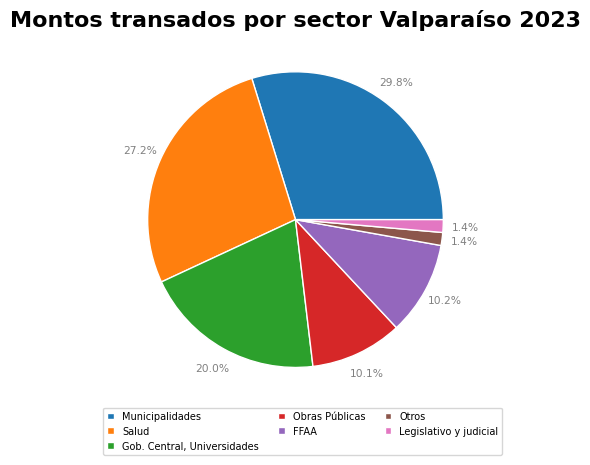

In [41]:
###################################################
###   Llenado diccionario/contexto y template   ###
###################################################

#Importar template
docu = DocxTemplate("docxtpl.docx")

#Settear diccionario nacional
contextoNac = {'ano' : str(anoReg),
               'anoM' : str(anoRegM),
               'mesI' : meses[mes_i - 1],   #llama nombre del mes para usar en reporte
               'mesF' : meses[mes_f - 1]}

#settear diccionario adicionales regionales
adicionalesReg = impAdicionalesReg()

dicGlob = {}


#Iterador de regiones/documentos
for r in listReg:
    print('')
    print('##############')
    print(r)
    print('##############')

    contexto = setContextoReg(r)

    rTotReg = TotReg.loc[TotReg['Region'] == r]
    contexto.update(agregarTotalesRegion(rTotReg, mndTotReg))

    #tmn Reg
    rTmnReg = extraerDataframe (TotRegBig, r, listColTmnReg)
    rTmnReg = fmtoDataframe(rTmnReg, listColTmnReg)
    print(rTmnReg)  
    contexto.update(dataframeDiciconario(rTmnReg, dtoTmnReg))

    #modalidad de compra
    rModReg = extraerDataframe (TotRegBig, r, listColModReg)
    rModReg = fmtoDataframe(rModReg, listColModReg)    
    contexto.update(dataframeDiciconario(rModReg, dtoModReg, topModReg))

    
    # proveedores a los que se le compra por región
    rPrvReg = extraerDataframe (TotRegBig, r, listColPrvReg)
    rPrvReg = fmtoDataframe(rPrvReg, listColPrvReg) 
    contexto.update(dataframeDiciconario(rPrvReg, dtoPrvReg, topPrvReg))

    # top Instituciones reg
    rInsReg = extraerDataframe (TotRegBig, r, listColInsReg)
    rInsReg = fmtoDataframe(rInsReg, listColInsReg)    
    contexto.update(dataframeDiciconario(rInsReg, dtoInsReg, topInsReg))

    #top rubro por region (usa dataframe personalizado)
    rRubReg = extraerDataframe(RubReg, r, listColRubReg)
    rRubReg = fmtoDataframe(rRubReg, listColRubReg)
    contexto.update(dataframeDiciconario(rRubReg, dtoRubReg, topRubReg)) # el dato TOTAL de este diccionario no será congruente con los otros
                                                                             # pporque se usa otra query
    
    rOCReg = extraerDataframe(TotRegBig, r, listColOCReg)
    rOCReg = fmtoDataframe(rOCReg, listColOCReg)
    contexto.update(dataframeDiciconario(rOCReg, dtoOCReg, topOCReg))

    rSecReg = extraerDataframe(TotRegBig, r, listColSecReg)
    rSecReg = fmtoDataframe(rSecReg, listColSecReg)
    print(rSecReg)
    titGrafSecReg = contexto['nomCt'] + ' ' + str(anoReg)
    contexto.update(agregarGrafMontoSectorRegion(rSecReg, titGrafSecReg)) #remover grafico despues de renderizar
    contexto.update(dataframeDiciconario(rSecReg, dtoSecReg, topSecReg))

    rCAReg = CAReg.loc[CAReg['Region'] == r]
    contexto.update(agregarCARegion(rCAReg, mndCAReg))

    contexto.update(adicionalesReg[r])

    contexto.update(contextoNac)
    
    
    print(contexto)
    dicGlob.update({r: contexto})

    docu.render(contexto)
    #os.remove(titGrafSecReg +'.png')    #según cantidad de gráficos se podría iterar
    #2023 plantilla cifras regionales
    nomDocu = contexto['ano'] + ' cifras regionales ' + contexto['nomCt'] + ' ' + contexto['mesI'] + '-' + contexto['mesF']
    docu.save('reportes/'+nomDocu+'.docx')


In [42]:
#######################################################
# Exporta planilla con todos los contextos regionales #
#######################################################

dfGlob = pd.DataFrame(dicGlob)
dfGlob.to_excel('dfGlob.xlsx')

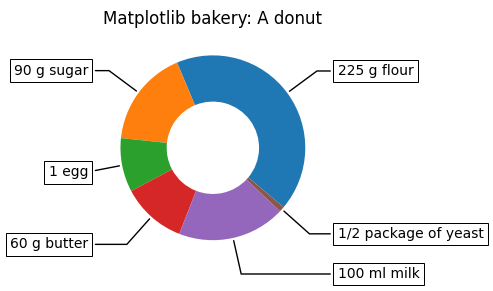

In [39]:
#####################################################
###    Referencia/Ejemplo para refinar gráfico    ###
#####################################################

#No afecta al programa
fig, ax = plt.subplots(figsize=(6, 3), subplot_kw=dict(aspect="equal"))

recipe = ["225 g flour",
          "90 g sugar",
          "1 egg",
          "60 g butter",
          "100 ml milk",
          "1/2 package of yeast"]

data = [225, 90, 50, 60, 100, 5]

wedges, texts = ax.pie(data, wedgeprops=dict(width=0.5), startangle=-40)

bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
kw = dict(arrowprops=dict(arrowstyle="-"),
          bbox=bbox_props, zorder=0, va="center")

for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = f"angle,angleA=0,angleB={ang}"
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    ax.annotate(recipe[i], xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
                horizontalalignment=horizontalalignment, **kw)

ax.set_title("Matplotlib bakery: A donut")

plt.show()
#Fin Ref---------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [40]:
###########################
#   Probar Crear Tablas   #
###########################

#Importar template
docu = DocxTemplate("tablas.docx")

#Settear diccionario nacional
contexto = {'ano' : str(anoReg),
               'anoM' : str(anoRegM)}

#settear diccionario adicionales regionales
adicionalesReg = impAdicionalesReg()

tttt =  """
        <table>
            <tr>
                <th>Institución</th>
                <th>Código orden de compra</th>
                <th>Motivo de la compra</th>
                <th>Proveedor</th>
                <th>Monto comprometido en US$</th>
            </tr>
            <tr>
                <td></td>
                <td></td>
                <td></td>
                <td></td>
                <td></td>
            </tr>
            
        </table>
        """

print('')

contexto['tablita'] = tttt

print(contexto)
docu.render(contexto)
docu.save('tablasnew.docx')


{'ano': '2023', 'anoM': '2022', 'tablita': '\n        <table>\n            <tr>\n                <th>Institución</th>\n                <th>Código orden de compra</th>\n                <th>Motivo de la compra</th>\n                <th>Proveedor</th>\n                <th>Monto comprometido en US$</th>\n            </tr>\n            <tr>\n                <td></td>\n                <td></td>\n                <td></td>\n                <td></td>\n                <td></td>\n            </tr>\n            \n        </table>\n        '}
